# **Klasifikasi Daun Sehat vs Daun Terinfeksi Virus dengan CNN dan Augmentasi Data Agresif.**
## Membangun, melatih, dan mengevaluasi model CNN paralel untuk klasifikasi gambar daun sehat vs daun terinfeksi virus, menggunakan augmentasi data agresif dan analisis iteratif untuk optimasi kinerja.

# **Memuat dan Pra-pemrosesan Data Daun**
Memuat dataset gambar daun (sehat dan terinfeksi virus) yang ditempatkan di Google Drive. Melakukan pra-pemrosesan data seperti mengubah ukuran gambar agar seragam, normalisasi piksel, dan augmentasi data untuk meningkatkan ketahanan model. Memastikan data dibagi menjadi set training, validation, dan testing.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Leaf_Dataset'
import os

TRAIN_DIR = os.path.join(DATASET_PATH, 'Training_Data')
VALIDATION_DIR = os.path.join(DATASET_PATH, 'Validation_Data')
TEST_DIR = os.path.join(DATASET_PATH, 'Testing_Data')

print(f"Training Data Directory: {TRAIN_DIR}")
print(f"Validation Data Directory: {VALIDATION_DIR}")
print(f"Testing Data Directory: {TEST_DIR}")

Training Data Directory: /content/drive/MyDrive/Leaf_Dataset/Training_Data
Validation Data Directory: /content/drive/MyDrive/Leaf_Dataset/Validation_Data
Testing Data Directory: /content/drive/MyDrive/Leaf_Dataset/Testing_Data


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from collections import Counter

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("ImageDataGenerators berhasil diinisialisasi.\n")

TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

try:
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    train_dist = Counter(train_generator.classes)
    val_dist   = Counter(validation_generator.classes)
    test_dist  = Counter(test_generator.classes)

    class_map = {v: k for k, v in train_generator.class_indices.items()}

    print("DETAIL DISTRIBUSI DATASET :")

    print("1. TRAINING SET :")
    for cls, count in train_dist.items():
        print(f"  {class_map[cls]} = {count}")
    print(f"  Total Training   = {sum(train_dist.values())}\n")

    print("2. VALIDATION SET :")
    for cls, count in val_dist.items():
        print(f"  {class_map[cls]} = {count}")
    print(f"  Total Validation = {sum(val_dist.values())}\n")

    print("3. TESTING SET :")
    for cls, count in test_dist.items():
        print(f"  {class_map[cls]} = {count}")
    print(f"  Total Testing    = {sum(test_dist.values())}\n")

    total_dataset = (
        sum(train_dist.values()) +
        sum(val_dist.values()) +
        sum(test_dist.values())
    )

    print(f"TOTAL DATASET KESELURUHAN : {total_dataset} GAMBAR")

except Exception as e:
    print(f"Terjadi kesalahan: {e}")
    print("Pastikan TRAIN_DIR, VALIDATION_DIR, dan TEST_DIR sudah benar.")

ImageDataGenerators berhasil diinisialisasi.

Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
DETAIL DISTRIBUSI DATASET :
1. TRAINING SET :
  Tomato__Tomato_YellowLeaf__Curl_Virus = 1050
  Tomato_healthy = 1050
  Total Training   = 2100

2. VALIDATION SET :
  Tomato__Tomato_YellowLeaf__Curl_Virus = 225
  Tomato_healthy = 225
  Total Validation = 450

3. TESTING SET :
  Tomato__Tomato_YellowLeaf__Curl_Virus = 225
  Tomato_healthy = 225
  Total Testing    = 450

TOTAL DATASET KESELURUHAN : 3000 GAMBAR


In [ ]:
import os
import hashlib
from collections import defaultdict

def compute_md5(image_path):
    """Hitung hash MD5 dari file gambar"""
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def check_duplicate_images(base_dir):
    hash_map = defaultdict(list)

    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(base_dir, subset)
        if not os.path.exists(subset_path):
            continue

        for root, _, files in os.walk(subset_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(root, file)
                    file_hash = compute_md5(file_path)
                    hash_map[file_hash].append(file_path)

    duplicates = {h: paths for h, paths in hash_map.items() if len(paths) > 1}

    return duplicates


dataset_path = "Leaf_Dataset"
duplicates = check_duplicate_images(dataset_path)

if duplicates:
    print("DITEMUKAN DUPLIKASI DATA:")
    for h, paths in duplicates.items():
        print("\nHash:", h)
        for p in paths:
            print(" -", p)
else:
    print("TIDAK ADA DUPLIKASI ANTAR SUBSET")

TIDAK ADA DUPLIKASI ANTAR SUBSET


## **Membangun Arsitektur Model CNN**
Membangun arsitektur Convolutional Neural Network (CNN) menggunakan TensorFlow/Keras. Arsitektur ini akan mencakup lapisan konvolusi, lapisan pooling, dan lapisan dense untuk klasifikasi biner (sehat vs. terinfeksi).


In [2]:
import tensorflow as tf
# KONFIGURASI INPUT
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# INISIALISASI MODEL
model = tf.keras.models.Sequential(
    name="CNN_Parallel_Leaf_Classifier"
)

# BLOK 1: EKSTRAKSI FITUR AWAL
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding='same',
    activation='relu',
    input_shape=INPUT_SHAPE,
    name="Conv1_LowLevel_Features"
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    name="Pool1_Downsampling"
))

# BLOK 2: EKSTRAKSI FITUR MENENGAH
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    activation='relu',
    name="Conv2_MidLevel_Features"
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    name="Pool2_Downsampling"
))

# BLOK 3: EKSTRAKSI FITUR TINGGI
model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    activation='relu',
    name="Conv3_HighLevel_Features"
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    name="Pool3_Downsampling"
))

# BLOK KLASIFIKASI
model.add(tf.keras.layers.Flatten(
    name="Flatten_Feature_Map"
))

model.add(tf.keras.layers.Dense(
    units=128,
    activation='relu',
    name="Dense_Feature_Embedding"
))

model.add(tf.keras.layers.Dropout(
    rate=0.5,
    name="Dropout_Anti_Overfitting"
))

# OUTPUT LAYER
model.add(tf.keras.layers.Dense(
    units=1,
    activation='sigmoid',
    name="Binary_Output_Healthy_vs_Infected"
))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Parallel_Leaf_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1_LowLevel_Features         │ (None, 224, 224, 32)   │           896 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1_Downsampling              │ (None, 112, 112, 32)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_MidLevel_Features         │ (None, 112, 112, 64)   │        18,496 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2_Downsampling              │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_HighLevel_Features        │ (None, 56, 56, 128)    │        73,856 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3_Downsampling              │ (None, 28, 28, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Feature_Map (Flatten)   │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Feature_Embedding (Dense) │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Anti_Overfitting        │ (None, 128)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Binary_Output_Healthy_vs_Infec… │ (None, 1)              │           129 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import tensorflow as tf
import pandas as pd

model.build(input_shape=(None, 224, 224, 3))
def ringkasan_model_bahasa_indonesia(model):
    data = []

    for layer in model.layers:
        output_shape = layer.output.shape

        output_shape = tuple(0 if dim is None else int(dim) for dim in output_shape)

        if "Conv" in layer.name:
            fungsi = "Mengekstraksi fitur visual dari citra (tepi, tekstur, pola)"
        elif "Pool" in layer.name:
            fungsi = "Mengurangi ukuran fitur untuk mempercepat komputasi"
        elif "Flatten" in layer.name:
            fungsi = "Mengubah fitur 2D menjadi vektor 1D"
        elif "Dense" in layer.name:
            fungsi = "Mengolah fitur untuk proses klasifikasi"
        elif "Dropout" in layer.name:
            fungsi = "Mengurangi overfitting dengan menonaktifkan neuron acak"
        else:
            fungsi = "Lapisan Klasifikasi Biner (Sehat vs Terinfeksi)"

        data.append({
            "Nama Layer": layer.name,
            "Jenis Layer": layer.__class__.__name__,
            "Ukuran Output": output_shape,
            "Jumlah Parameter": layer.count_params(),
            "Fungsi Layer": fungsi
        })

    df = pd.DataFrame(data)

    print("RINGKASAN ARSITEKTUR MODEL CNN (BAHASA INDONESIA)")
    print(df.to_string(index=False))
    print("Total Parameter Model        :", model.count_params())
    print("Parameter Dapat Dilatih      :", sum(
        tf.keras.backend.count_params(w) for w in model.trainable_weights))
    print("Parameter Tidak Dapat Dilatih:", sum(
        tf.keras.backend.count_params(w) for w in model.non_trainable_weights))

    print("\nTugas Model : Klasifikasi Biner")
    print("Kelas       : Daun Sehat vs Daun Terinfeksi Virus")

ringkasan_model_bahasa_indonesia(model)

RINGKASAN ARSITEKTUR MODEL CNN (BAHASA INDONESIA)
                       Nama Layer  Jenis Layer     Ukuran Output  Jumlah Parameter                                                Fungsi Layer
          Conv1_LowLevel_Features       Conv2D (0, 224, 224, 32)               896 Mengekstraksi fitur visual dari citra (tepi, tekstur, pola)
               Pool1_Downsampling MaxPooling2D (0, 112, 112, 32)                 0         Mengurangi ukuran fitur untuk mempercepat komputasi
          Conv2_MidLevel_Features       Conv2D (0, 112, 112, 64)             18496 Mengekstraksi fitur visual dari citra (tepi, tekstur, pola)
               Pool2_Downsampling MaxPooling2D   (0, 56, 56, 64)                 0         Mengurangi ukuran fitur untuk mempercepat komputasi
         Conv3_HighLevel_Features       Conv2D  (0, 56, 56, 128)             73856 Mengekstraksi fitur visual dari citra (tepi, tekstur, pola)
               Pool3_Downsampling MaxPooling2D  (0, 28, 28, 128)                 0         M

### **Visualisasi Foto Daun Sehat dan Terinfeksi Virus**
Menampilkan contoh gambar daun yang dikategorikan sebagai 'sehat' dan 'terinfeksi virus' dari dataset pelatihan untuk memberikan gambaran yang lebih jelas tentang perbedaan visual di antara kedua kelas tersebut.

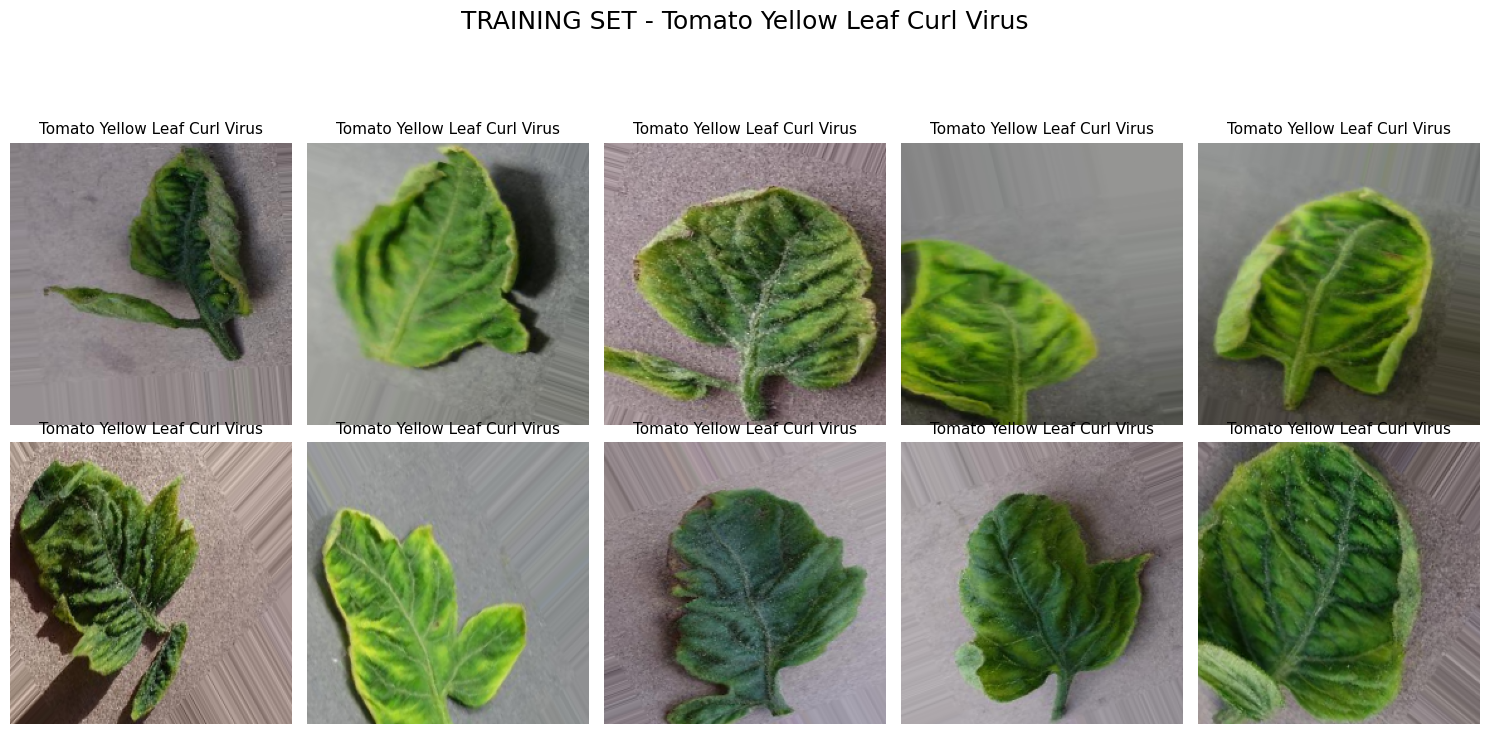

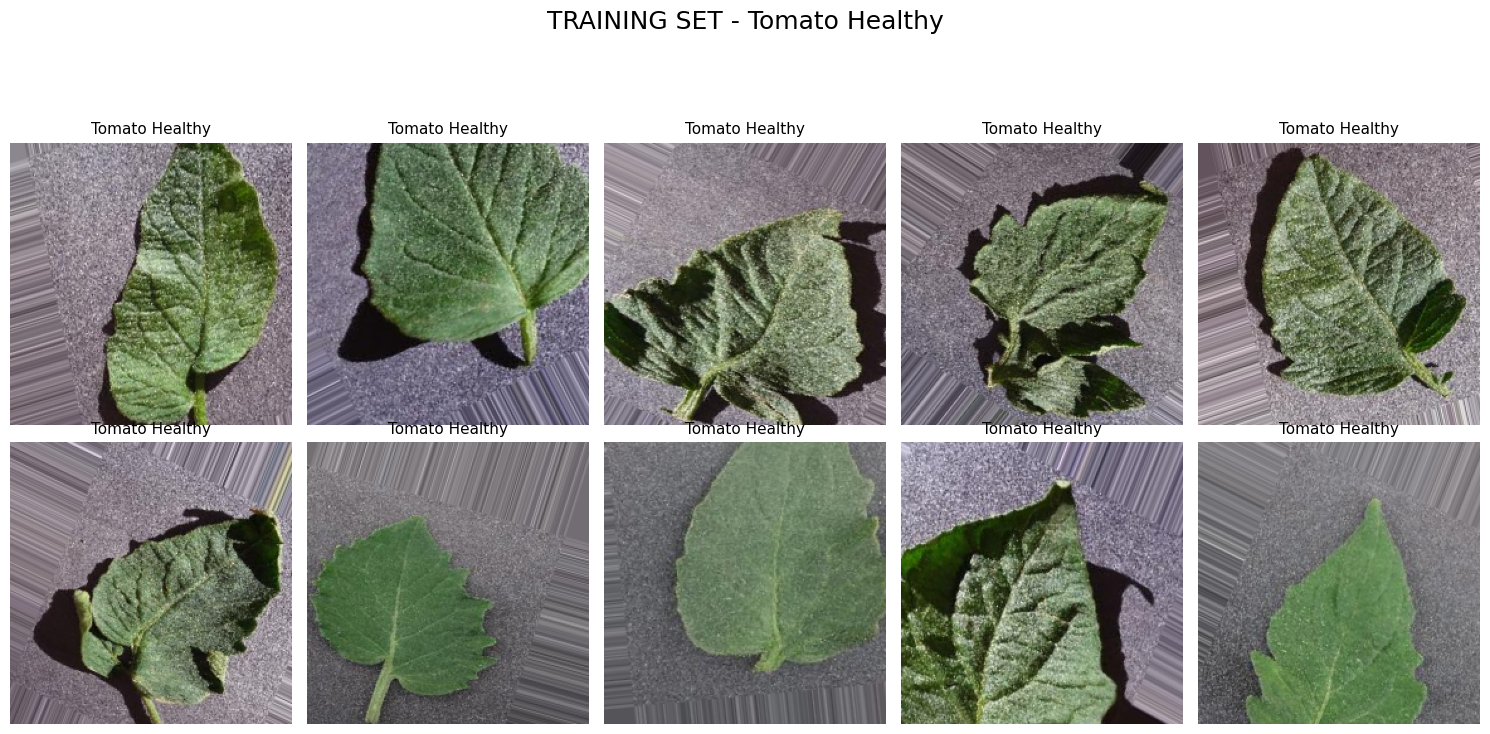

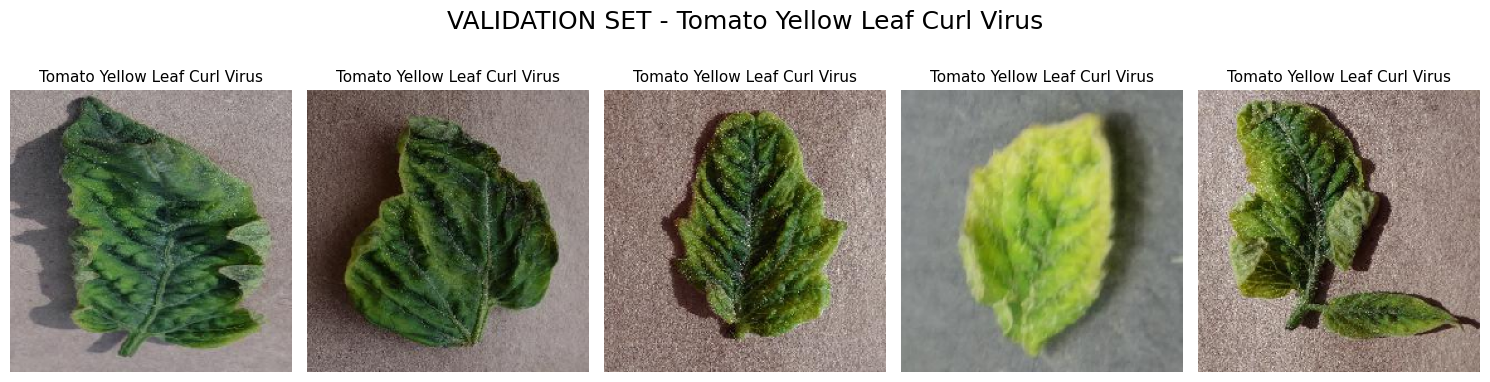

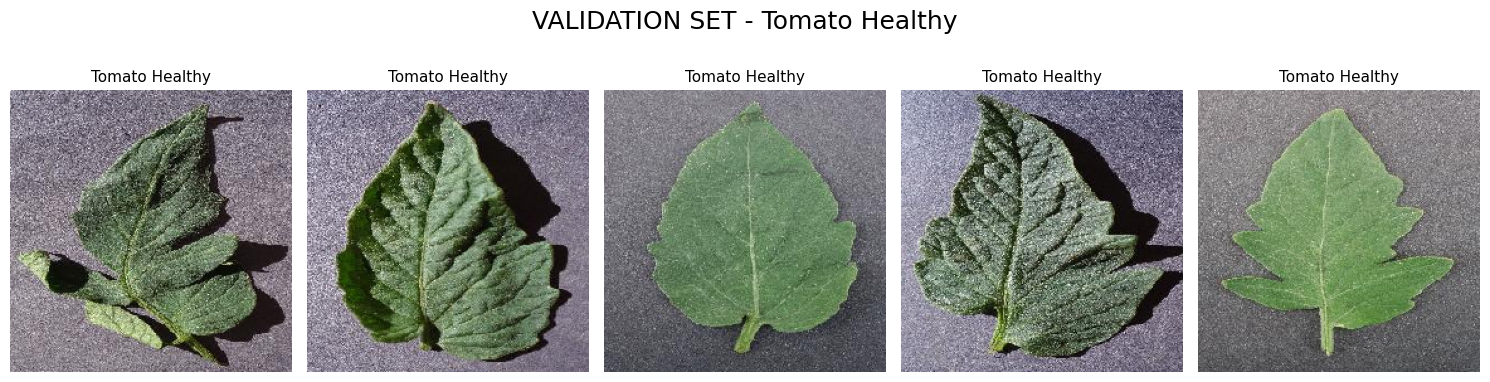

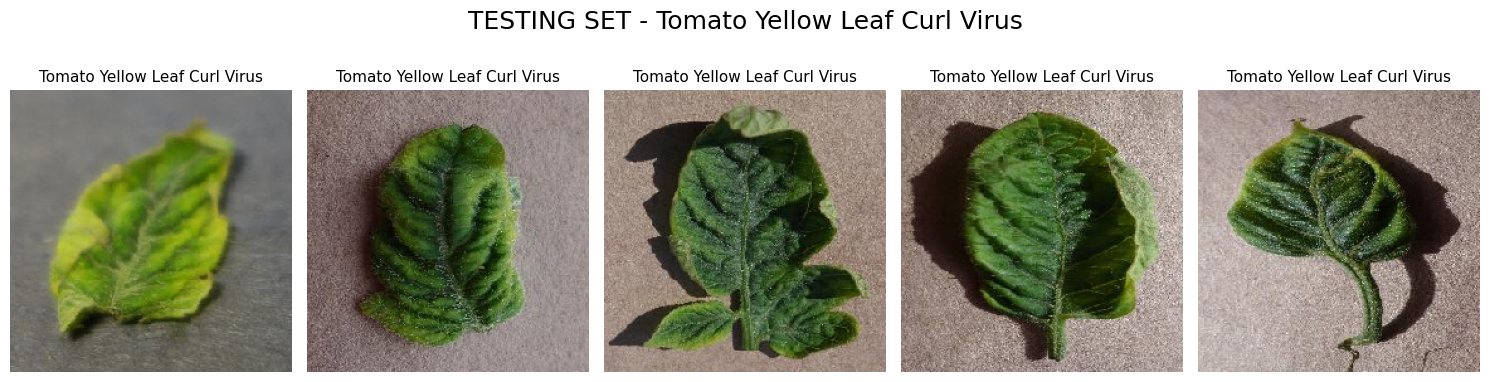

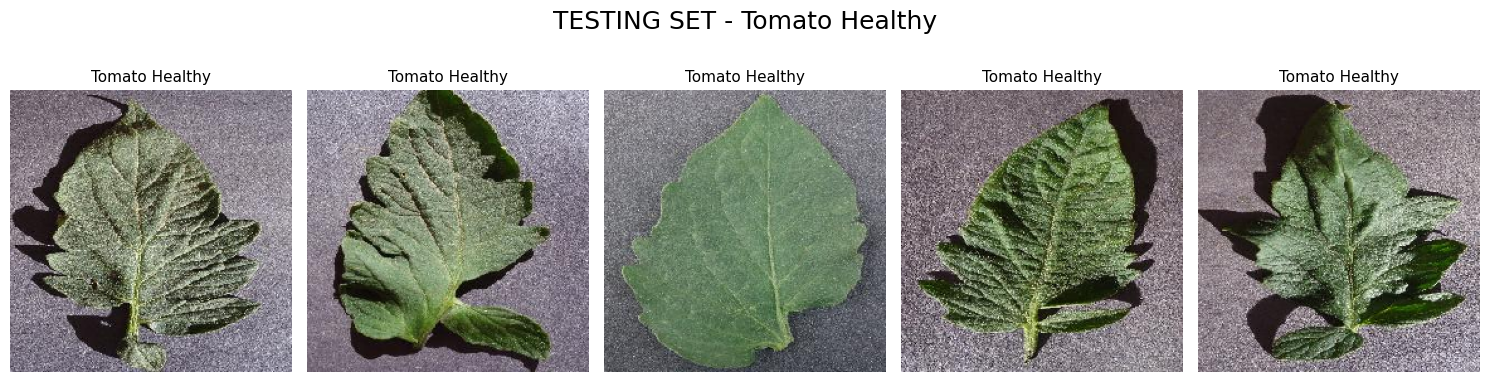

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def kumpulkan_gambar(generator, jumlah_per_kelas):
    generator.reset()

    virus_imgs = []
    healthy_imgs = []

    while len(virus_imgs) < jumlah_per_kelas or len(healthy_imgs) < jumlah_per_kelas:
        images, labels = next(generator)

        for img, lbl in zip(images, labels):
            if lbl == 0 and len(virus_imgs) < jumlah_per_kelas:
                virus_imgs.append(img)
            elif lbl == 1 and len(healthy_imgs) < jumlah_per_kelas:
                healthy_imgs.append(img)

            if len(virus_imgs) >= jumlah_per_kelas and len(healthy_imgs) >= jumlah_per_kelas:
                break

    return virus_imgs, healthy_imgs


def tampilkan_subset(generator, subset_name, jumlah_per_kelas):
    virus_images, healthy_images = kumpulkan_gambar(generator, jumlah_per_kelas)

    if jumlah_per_kelas == 10:
        ROWS, COLS = 2, 5
        FIG_H = 8
    else:
        ROWS, COLS = 1, 5
        FIG_H = 4

    plt.figure(figsize=(15, FIG_H))
    plt.suptitle(
        f"{subset_name.upper()} SET - Tomato Yellow Leaf Curl Virus",
        fontsize=18
    )

    for i in range(jumlah_per_kelas):
        plt.subplot(ROWS, COLS, i + 1)
        plt.imshow(virus_images[i])
        plt.title("Tomato Yellow Leaf Curl Virus", fontsize=11)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

    plt.figure(figsize=(15, FIG_H))
    plt.suptitle(
        f"{subset_name.upper()} SET - Tomato Healthy",
        fontsize=18
    )

    for i in range(jumlah_per_kelas):
        plt.subplot(ROWS, COLS, i + 1)
        plt.imshow(healthy_images[i])
        plt.title("Tomato Healthy", fontsize=11)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

tampilkan_subset(train_generator, "Training", jumlah_per_kelas=10)
tampilkan_subset(validation_generator, "Validation", jumlah_per_kelas=5)
tampilkan_subset(test_generator, "Testing", jumlah_per_kelas=5)

## Pelatihan Model CNN Serial

In [ ]:
import time
import tensorflow as tf
from collections import Counter
import math

counter = Counter(train_generator.labels)
print("Distribusi kelas (training):", counter)

class_weights = {int(k): 1.0 for k in counter.keys()}
print("Class weights:", class_weights)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

EPOCHS = 10
BATCH_SIZE = 32

STEPS_PER_EPOCH = math.ceil(train_generator.samples / BATCH_SIZE)
VAL_STEPS = math.ceil(validation_generator.samples / BATCH_SIZE)

print("Starting serial model training...")
start_time = time.time()

history_serial = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_STEPS,
    class_weight=class_weights,
    verbose=1
)

end_time = time.time()
serial_training_time = end_time - start_time

print("Serial model training completed successfully.")
print(f"Total training time (Serial): {serial_training_time:.2f} seconds")

Distribusi kelas (training): Counter({np.int32(0): 1050, np.int32(1): 1050})
Class weights: {0: 1.0, 1: 1.0}
Starting serial model training...
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.9889 - loss: 0.0368 - precision: 0.9875 - recall: 0.9908 - val_accuracy: 0.9933 - val_loss: 0.0190 - val_precision: 0.9868 - val_recall: 1.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.9945 - loss: 0.0142 - precision: 0.9915 - recall: 0.9975 - val_accuracy: 1.0000 - val_loss: 3.1190e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.9941 - loss: 0.0121 - precision: 0.9988 - recall: 0.9895 - val_accuracy: 0.9978 - val_loss: 0.0181 - val_precision: 0.9956 - val_recall: 1.0000
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 1.0000 - loss: 4.5784e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.7711e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/1

## Pelatihan Model dengan CNN Paralel Terdistribusi
Melatih kembali model yang telah dimodifikasi menggunakan data pelatihan dan validasi yang sudah ada, tetapi sekarang dalam lingkungan terdistribusi. Fungsi `model.fit()` akan secara otomatis memanfaatkan strategi distribusi yang telah diatur.



In [ ]:
import time
import tensorflow as tf
from collections import Counter
import math

counter = Counter(train_generator.labels)
print("Distribusi kelas (training):", counter)

class_weights = {int(k): 1.0 for k in counter.keys()}
print("Class weights:", class_weights)

EPOCHS = 10
BATCH_SIZE = 32

strategy = tf.distribute.MirroredStrategy()
print("Number of devices used for parallel training:", strategy.num_replicas_in_sync)

with strategy.scope():
    parallel_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    parallel_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )


STEPS_PER_EPOCH = math.ceil(train_generator.samples / BATCH_SIZE)
VAL_STEPS = math.ceil(validation_generator.samples / BATCH_SIZE)

print("Starting parallel (distributed) model training...")
start_time_parallel = time.time()

history_parallel = parallel_model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_STEPS,
    class_weight=class_weights,
    verbose=1
)

end_time_parallel = time.time()
parallel_training_time = end_time_parallel - start_time_parallel

print("Parallel model training completed successfully.")
print(f"Total training time (Parallel): {parallel_training_time:.2f} seconds")

Distribusi kelas (training): Counter({np.int32(0): 1050, np.int32(1): 1050})
Class weights: {0: 1.0, 1: 1.0}
Number of devices used for parallel training: 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting parallel (distributed) model training...
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.6431 - loss: 0.9893 - precision: 0.6512 - recall: 0.7029 - val_accuracy: 0.9867 - val_loss: 0.0454 - val_precision: 0.9955 - val_recall: 0.9778
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.9482 - loss: 0.1501 - precision: 0.9451 - recall: 0.9532 - val_accuracy: 0.9422 - val_loss: 0.1288 - val_precision: 0.8996 - val_recall: 0.9956
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.9855 - loss: 0.0465 - precision: 0.9873 - recall: 0.9832 - val_accuracy: 0.9600 - val_loss: 0.1234 - val_precision: 0.9295 - val_recall: 0.9956
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.9878 - loss: 0.0427 - precision: 0.9866 - recall: 0.9887 - val_accuracy: 0.9978 - val_loss: 0.0070 - val_precision: 1.0000 - val_recall: 0.9956
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.9970 - loss: 0.0189 - precision: 0.9984 - recall:

# **Evaluasi Strategi Paralel Terdistribusi**

Imported libraries for model evaluation.
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step

Classification Report:
                                       precision    recall  f1-score   support

Tomato__Tomato_YellowLeaf__Curl_Virus       0.51      0.51      0.51       225
                       Tomato_healthy       0.51      0.51      0.51       225

                             accuracy                           0.51       450
                            macro avg       0.51      0.51      0.51       450
                         weighted avg       0.51      0.51      0.51       450


Confusion Matrix:
[[115 110]
 [110 115]]


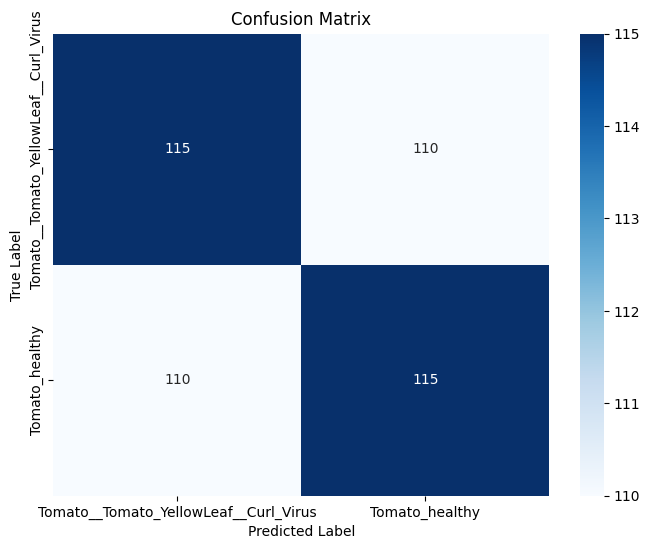

Model evaluation complete. Classification report and confusion matrix displayed.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Imported libraries for model evaluation.")

validation_generator.reset()

Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)

y_pred_classes = (Y_pred > 0.5).astype(int)

y_true = validation_generator.classes

class_labels = list(train_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Model evaluation complete. Classification report and confusion matrix displayed.")


# **Perbandingan Pelatihan Model Serial dan Paralel + Break Even Point**

Bagian ini membahas perbandingan hasil pelatihan model yang dilatih secara serial dan secara paralel. Analisis mencakup metrik akurasi, loss, dan waktu eksekusi, sekaligus memperkirakan titik Break Even Point (BEP) di mana paralel mulai lebih efisien dibanding serial, serta trade-off antara akurasi dan penghematan waktu.


In [ ]:
import numpy as np

N = 10

serial_train_acc = np.mean(history_serial.history['accuracy'][-N:])
parallel_train_acc = np.mean(history_parallel.history['accuracy'][-N:])

serial_val_acc = np.mean(history_serial.history['val_accuracy'][-N:])
parallel_val_acc = np.mean(history_parallel.history['val_accuracy'][-N:])

serial_train_loss = np.mean(history_serial.history['loss'][-N:])
parallel_train_loss = np.mean(history_parallel.history['loss'][-N:])

serial_val_loss = np.mean(history_serial.history['val_loss'][-N:])
parallel_val_loss = np.mean(history_parallel.history['val_loss'][-N:])

time_diff_percent = (
    (serial_training_time - parallel_training_time)
    / serial_training_time
) * 100

print("PERBANDINGAN KINERJA MODEL SERIAL vs PARALEL")

print("\nAKURASI TRAINING")
print(f"Serial   : {serial_train_acc:.4f} ({serial_train_acc*100:.2f}%)")
print(f"Paralel  : {parallel_train_acc:.4f} ({parallel_train_acc*100:.2f}%)")

print("\nAKURASI VALIDASI")
print(f"Serial   : {serial_val_acc:.4f} ({serial_val_acc*100:.2f}%)")
print(f"Paralel  : {parallel_val_acc:.4f} ({parallel_val_acc*100:.2f}%)")

print("\nLOSS TRAINING")
print(f"Serial   : {serial_train_loss:.4f} ({serial_train_loss*100:.2f}%)")
print(f"Paralel  : {parallel_train_loss:.4f} ({parallel_train_loss*100:.2f}%)")

print("\nLOSS VALIDASI")
print(f"Serial   : {serial_val_loss:.4f} ({serial_val_loss*100:.2f}%)")
print(f"Paralel  : {parallel_val_loss:.4f} ({parallel_val_loss*100:.2f}%)")

print("\nWAKTU EKSEKUSI")
print(f"Serial   : {serial_training_time:.2f} detik")
print(f"Paralel  : {parallel_training_time:.2f} detik")
print(f"Penghematan Waktu : {time_diff_percent:.2f}%")

PERBANDINGAN KINERJA MODEL SERIAL vs PARALEL

AKURASI TRAINING
Serial   : 0.9900 (99.00%)
Paralel  : 0.9642 (96.42%)

AKURASI VALIDASI
Serial   : 0.9933 (99.33%)
Paralel  : 0.9778 (97.78%)

LOSS TRAINING
Serial   : 0.0415 (4.15%)
Paralel  : 0.1004 (10.04%)

LOSS VALIDASI
Serial   : 0.0263 (2.63%)
Paralel  : 0.0759 (7.59%)

WAKTU EKSEKUSI
Serial   : 3158.55 detik
Paralel  : 3149.36 detik
Penghematan Waktu : 0.29%


# **Analisis Break Even Point (BEP)**

In [ ]:
print("ANALISIS BREAK EVEN POINT (BEP)")
# Selisih waktu eksekusi
selisih_waktu = serial_training_time - parallel_training_time

# Persentase efisiensi waktu
efisiensi_waktu = (selisih_waktu / serial_training_time) * 100

print(f"Waktu Training Serial   : {serial_training_time:.2f} detik")
print(f"Waktu Training Paralel  : {parallel_training_time:.2f} detik")
print(f"Selisih Waktu           : {selisih_waktu:.2f} detik")
print(f"Efisiensi Waktu Paralel : {efisiensi_waktu:.2f}%")

print("\nINTERPRETASI BEP:")

if parallel_training_time < serial_training_time:
    print(
        "- Break Even Point (BEP) TERCAPAI\n"
        "- Artinya, pada konfigurasi ini, eksekusi paralel\n"
        "  sudah memberikan keuntungan waktu dibandingkan serial.\n"
        "- Namun, keuntungan waktu masih relatif kecil,\n"
        "  sehingga paralelisasi belum terlalu signifikan."
    )
else:
    print(
        "- Break Even Point (BEP) BELUM tercapai\n"
        "- Artinya, overhead paralelisasi masih lebih besar\n"
        "  dibandingkan keuntungan komputasi paralel.\n"
        "- Perlu dataset lebih besar atau GPU lebih dari satu\n"
        "  agar BEP dapat tercapai."
    )

print("\nKESIMPULAN:")
print(
    "- BEP digunakan untuk menentukan apakah paralelisasi\n"
    "  benar-benar menguntungkan dari sisi waktu.\n"
    "- Pada eksperimen ini, BEP lebih bersifat ANALITIS\n"
    "  daripada PRAKTIS karena selisih waktu sangat kecil."
)

ANALISIS BREAK EVEN POINT (BEP)
Waktu Training Serial   : 3158.55 detik
Waktu Training Paralel  : 3149.36 detik
Selisih Waktu           : 9.19 detik
Efisiensi Waktu Paralel : 0.29%

INTERPRETASI BEP:
- Break Even Point (BEP) TERCAPAI
- Artinya, pada konfigurasi ini, eksekusi paralel
  sudah memberikan keuntungan waktu dibandingkan serial.
- Namun, keuntungan waktu masih relatif kecil,
  sehingga paralelisasi belum terlalu signifikan.

KESIMPULAN:
- BEP digunakan untuk menentukan apakah paralelisasi
  benar-benar menguntungkan dari sisi waktu.
- Pada eksperimen ini, BEP lebih bersifat ANALITIS
  daripada PRAKTIS karena selisih waktu sangat kecil.


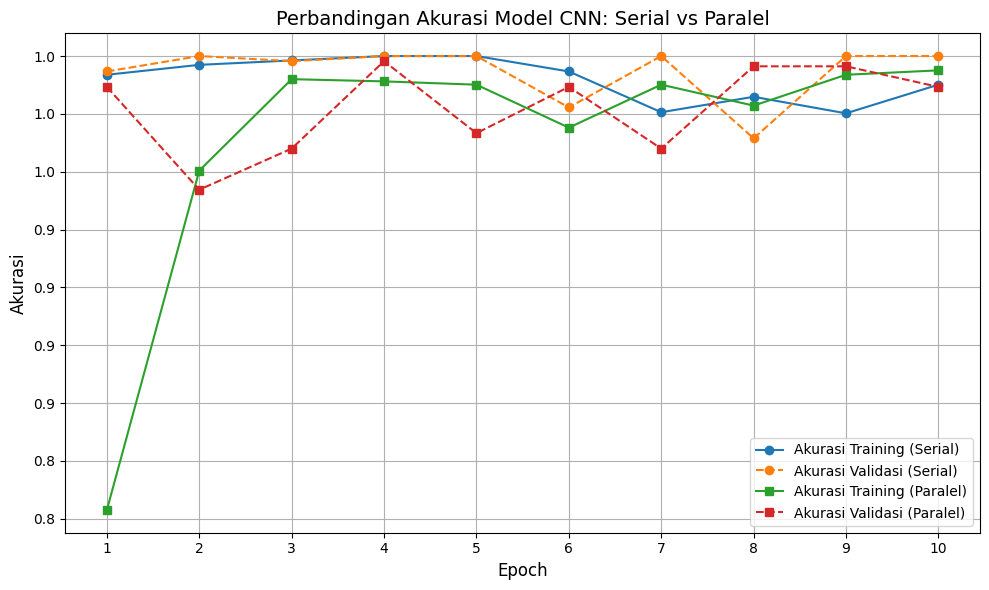

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

epoch_serial = len(history_serial.history['accuracy'])
epoch_parallel = len(history_parallel.history['accuracy'])

epochs = range(1, epoch_serial + 1)

def format_persen(x, pos):
    return f"{x:.1f}"

formatter = FuncFormatter(format_persen)

plt.figure(figsize=(10, 6))

# MODEL SERIAL
plt.plot(
    epochs,
    history_serial.history['accuracy'],
    marker='o',
    label='Akurasi Training (Serial)'
)
plt.plot(
    epochs,
    history_serial.history['val_accuracy'],
    marker='o',
    linestyle='--',
    label='Akurasi Validasi (Serial)'
)

# MODEL PARALEL
plt.plot(
    epochs,
    history_parallel.history['accuracy'],
    marker='s',
    label='Akurasi Training (Paralel)'
)
plt.plot(
    epochs,
    history_parallel.history['val_accuracy'],
    marker='s',
    linestyle='--',
    label='Akurasi Validasi (Paralel)'
)

plt.title('Perbandingan Akurasi Model CNN: Serial vs Paralel', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Nilai Akurasi', fontsize=12)

plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

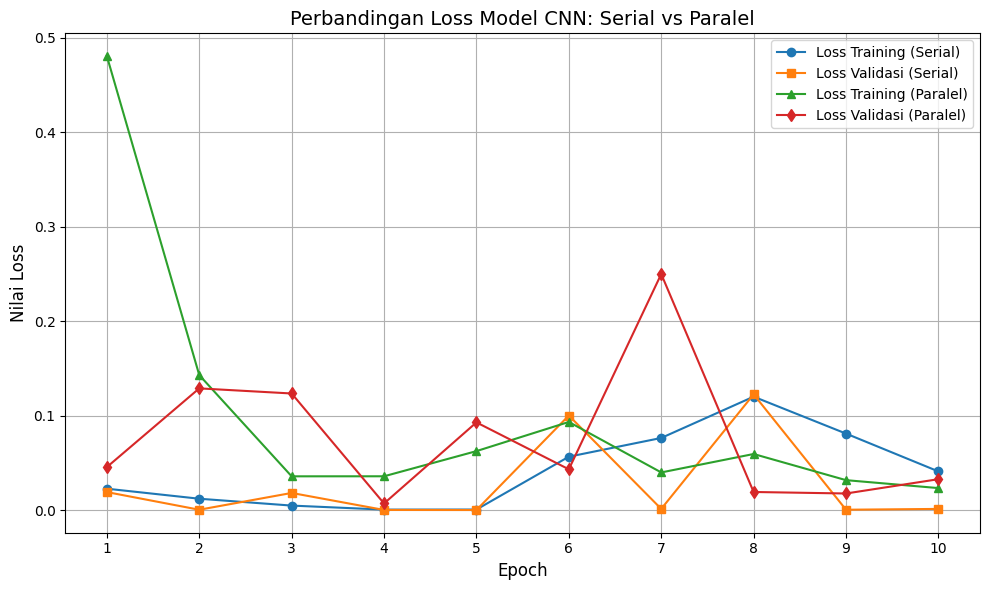

In [ ]:
import matplotlib.pyplot as plt

MAX_EPOCH = 10

epoch_serial = len(history_serial.history['loss'])
epoch_parallel = len(history_parallel.history['loss'])

epochs = range(1, min(MAX_EPOCH, epoch_serial, epoch_parallel) + 1)

plt.figure(figsize=(10, 6))

plt.plot(
    epochs,
    history_serial.history['loss'][:len(epochs)],
    marker='o',
    label='Loss Training (Serial)'
)

plt.plot(
    epochs,
    history_serial.history['val_loss'][:len(epochs)],
    marker='s',
    label='Loss Validasi (Serial)'
)

plt.plot(
    epochs,
    history_parallel.history['loss'][:len(epochs)],
    marker='^',
    label='Loss Training (Paralel)'
)

plt.plot(
    epochs,
    history_parallel.history['val_loss'][:len(epochs)],
    marker='d',
    label='Loss Validasi (Paralel)'
)

plt.title('Perbandingan Loss Model CNN: Serial vs Paralel', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Nilai Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.tight_layout()
plt.show()